Here is just a demo, using the familiar functions from https://matthew-brett.github.io/cfd2020/mean-slopes/mean_and_slopes.html to predict events (number of accidents, number of births) as a function of time, for a single country.

`A` is a simulated country, and the datapoint at each timepoint is a simulated number of events that occured in that timepoint.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# creating some fake time series data

data_1 = np.abs(np.arange(30) + np.random.normal(0, 5, size = 30)).astype('int')

data_1 = np.append(data_1, np.arange(30, 0, -1) + np.random.normal(0, 2, size = 30)).astype('int')


df = pd.DataFrame({'A': data_1})

df.index.rename('Time point:', inplace = True)

df.head(10)

,A
Time point:,
0,4
1,1
2,0
3,1
4,4
5,7
6,0
7,12
8,12


We can see that this data has a clear change in trend. If this change occured when there was a big change in the country, we might conclude that the change caused the change in the trend. Let's say the events are `number of births per 1000 people` and at timepoint 27, the government introduced new taxes that disincentivized having children. It definitely looks like this policy might have led to a reduced number of births. 

We can use linear regression quantify the change in trend.

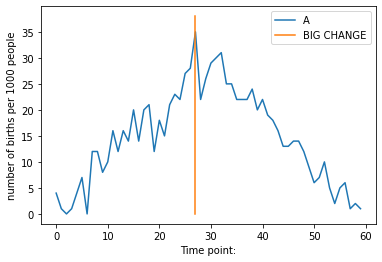

In [15]:
df.plot()
plt.plot([27,27], [0, 38], label = 'BIG CHANGE')
plt.ylabel('number of births per 1000 people')
plt.legend();

Creating a dataframe of the time series points BEFORE the big change:

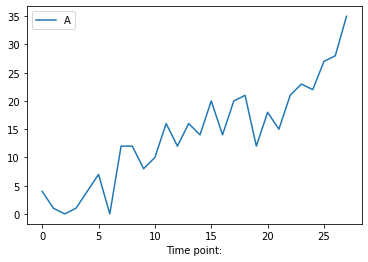

In [3]:
before_change = df.loc[0 : 27].copy()

before_change.plot();

Creating a dataframe of the time series points AFTER the big change:

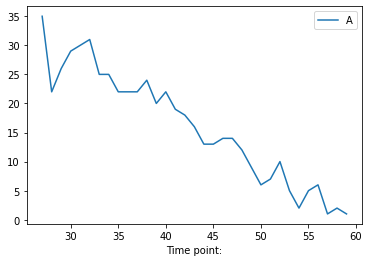

In [4]:
after_change = df.loc[27:].copy()

after_change.plot();

We can treat the timepoints as the predictor variable, and look at the number of events as the outcome variable. (*NB:* if the dates are in the datetime format (e.g. https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html), then they will need to be converted to ints or floats before using them as a predictor...).

If we perform a linear regression over a particular time period, and the slope is positive, it means that the number of events is increasing in that time period. A negative slope means the number of events is decreasing in that time period.

In [5]:
# adapting the sum of squared error function from https://matthew-brett.github.io/cfd2020/mean-slopes/using_minimize.html

def sos_error_for_minimize(intercept_and_slope, time, events):
    # intercept_and_slope has two elements, the intercept and the slope.
    # time is the series of timepoints to predict from
    # events are the number of events in each timepoint
    intercept = intercept_and_slope[0]
    slope = intercept_and_slope[1]
    predicted = intercept + time * slope
    error =  events - predicted
    return np.sum(error ** 2)

In [6]:
# testing the function on the whole timeseries (df.index contains the time points, df['A'] contains the number of events for
# each timepoint)
sos_error_for_minimize([1,1], df.index, df['A'])

37908

If we minimize the sum of squares function on the timepoints BEFORE the big change:

In [7]:
from scipy.optimize import minimize

min_res_before = minimize(sos_error_for_minimize, [1, 1], args = (before_change.index, before_change['A']))
min_res_before

      fun: 344.9039408867002
 hess_inv: array([[ 0.06773386, -0.00369457],
       [-0.00369457,  0.00027367]])
      jac: array([-7.62939453e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([0.45812789, 1.00574713])

And then we minimize the sum of squares function on the timepoints AFTER the big change:

In [8]:
min_res_after = minimize(sos_error_for_minimize, [1, 1], args = (after_change.index, after_change['A']))
min_res_after

      fun: 201.95588235302895
 hess_inv: array([[ 3.24142098e-01, -7.18582767e-03],
       [-7.18582767e-03,  1.67112275e-04]])
      jac: array([ 0.00000000e+00, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([57.41912504, -0.96323547])

In [9]:
print('The slope BEFORE the change =', min_res_before.x[1])
print('The slope AFTER the change =', min_res_after.x[1])

The slope BEFORE the change = 1.0057471293754539
The slope AFTER the change = -0.9632354654262826


A positive slope means that, on average, the number of births increased for a 1-unit increase in time.

A negative slope means that, on average, the number of births decreased for a 1-unit increase in time.

# IMPORTANT CAUTION

This is quite an informal method of looking at trends in time series. It will give descriptive, indicative evidence about the trend before and after an intervention - based on the sign of the slope before/after - but we cannot test the significance of the slopes in the normal way (e.g. we can't use the method from https://matthew-brett.github.io/cfd2020/mean-slopes/inference_on_slopes.html). So this method should be augmented with a different method to actually test the before/after difference.

This is because of the nature of time series data, which is why they require specialized statistical methods. There's an explanation of the problem here: https://stats.stackexchange.com/questions/473076/permutation-tests-and-exchangeability/473108#473108